In [168]:
import pandas as pd
import numpy as np
seed = 42

In [169]:
df =pd.read_csv('C:\\Users\\morriwg1\\OneDrive - Vanderbilt\\Documents\\GitHub\\behavioral-data-science\\behavioral-data-science\\data\\student_math\\student_math_clean.csv')
df = df[['study_time', 'class_failures', 'school_support', 'family_support', 'higher_ed', 'internet_access', 'health', 'absences', 'extra_paid_classes']]
# Convert outcome variable to integer
df['extra_paid_classes'].replace(to_replace='yes', value=1, inplace=True)
df['extra_paid_classes'].replace(to_replace='no', value=0, inplace=True)
# Convert all categorical variables to dummy variables
df = pd.get_dummies(df, drop_first=True)

In [170]:
df.columns

Index(['class_failures', 'health', 'absences', 'extra_paid_classes',
       'study_time_5 to 10 hours', 'study_time_<2 hours',
       'study_time_>10 hours', 'school_support_yes', 'family_support_yes',
       'higher_ed_yes', 'internet_access_yes'],
      dtype='object')

In [174]:
X = df[['class_failures', 'health', 'absences',
       'study_time_5 to 10 hours', 'study_time_<2 hours',
       'study_time_>10 hours', 'school_support_yes', 'family_support_yes',
       'higher_ed_yes', 'internet_access_yes']]
Y = df['extra_paid_classes']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

## Logistic Regression using K-Fold Cross-Validation

In [175]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

k = 5

kfold = KFold(n_splits=k, random_state=seed, shuffle=True)
model = LogisticRegression()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
# Output the accuracy. Calculate the mean and sd across all folds.
print("Classification F1: %.3f%% (sd = %.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Classification F1: 62.981% (sd = 6.958%)


## Bootstrapping

In [176]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

models_accuracy=[]
split = round(len(X_train)*0.8) # this defines the split
num_iters = 100

for i in range(num_iters):
    # resample the training set with replacement
    X_boot = resample(X_train, replace=True, n_samples=len(X_train), random_state=i)
    # collect outcomes with the same indices
    Y_boot = Y_train[X_boot.index]

    # convert the bootstrapped sample into train and test sets
    X_boot_train = X_boot.reset_index(drop=True)[:split]
    Y_boot_train = Y_boot.reset_index(drop=True)[:split].values.ravel()
    X_boot_test = X_boot.reset_index(drop=True)[split:]
    Y_boot_test = Y_boot.reset_index(drop=True)[split:].values.ravel()

    # train the model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_boot_train, Y_boot_train)

    # test the model against the bootstrapped test set
    Y_boot_pred = model.predict(X_boot_test)
    accuracy = accuracy_score(Y_boot_test, Y_boot_pred)
    
    # add the accuracy to the list
    models_accuracy.append(accuracy)

# print the average accuracy of the bootstrapped samples
print("Bootstrapped Mean F1 = {}".format(sum(models_accuracy)/num_iters))

Bootstrapped Mean F1 = 0.6663492063492064


## Train and Test the Logistic Regression Model

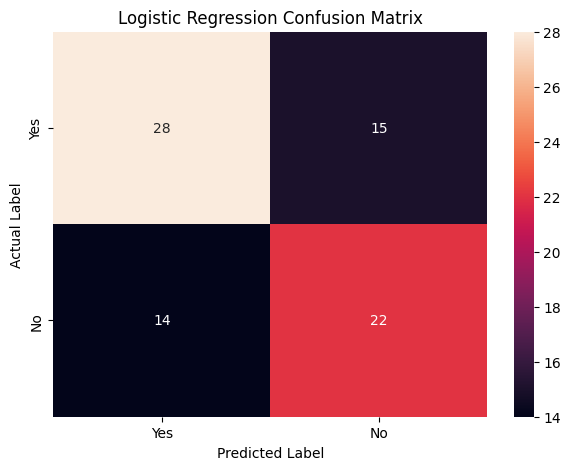

In [182]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm 

model = LogisticRegression()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
matrix = np.array(confusion_matrix(Y_test, predicted))
fig, ax = plt.subplots(figsize=(7,5)) 
sns.heatmap(pd.DataFrame(matrix, index=['Yes', 'No'], columns = ['Yes', 'No']), annot=True, fmt='g', ax=ax)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [183]:
report = classification_report(Y_test, predicted)
print('Logistic Regression Classification Report')
print(report)

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.67      0.65      0.66        43
           1       0.59      0.61      0.60        36

    accuracy                           0.63        79
   macro avg       0.63      0.63      0.63        79
weighted avg       0.63      0.63      0.63        79



In [193]:
predictors = ['intercept']
coefficients = [model.intercept_[0]]
p = ['']

scores, pvals = chi2(X_train, Y_train)
for i in range(len(X_train.columns)):
    predictors.append(list(X_train.columns)[i]) 
    coefficients.append(model.coef_[0][i])
    p.append(pvals[i])

pd.DataFrame({'predictors':predictors, 'coefficients': coefficients, 'p':p})

,predictors,coefficients,p
0,intercept,-2.588051,
1,class_failures,-0.409963,0.000025
2,health,-0.059309,0.328017
3,absences,-0.002089,0.634468
4,study_time_5 to 10 hours,-0.022814,0.454721
5,study_time_<2 hours,-0.447924,0.009977
6,study_time_>10 hours,0.352357,0.055998
7,school_support_yes,-0.420614,0.718861
8,family_support_yes,1.095675,0.000695
9,higher_ed_yes,1.632404,0.336967
